In [77]:
import audio_functions as af
from audio_file_iterator import iter as audio_file_iterator
import plot
import soundfile as sf
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing of the audio files
Perform some steps to preprocess audio files and convert them into a feature vector
## Preprocess converted WAV files
### Read in the audio data from the directory structure

In [78]:
raw_audio_data = [ sf.read(audio_file_name, dtype='float32') for audio_file_name in audio_file_iterator()]

Processing genre directory '06 Deep House'
   Processed 360 files          
Processing genre directory '09 Disco Funk'
   Processed 298 files          
Processing genre directory '12 Chinese Traditional'
   Processed 300 files          
Processing genre directory '15 Reggaeton Pop'
   Processed 322 files          
Processing genre directory 'Keyboard Collection'
   Processed 164 files          


### perform sequential several preprocessing steps
 - slice audio to 3s unit length snippets (zero-padded if shorter)
 - convert track to mono audio
 - downsample audio files to 4kBit

define and prepare preprocessing steps:

In [79]:
downsample_rate = 4000
unit_length = 3000

to_mono = lambda t : (af.to_mono_channel(t[0]), t[1])
slice_length = lambda t : (af.slice_to_length(t[0], t[1], unit_length), t[1])
resample = lambda t : (af.resample(t[0], t[1], downsample_rate), t[1])

preprocessing_steps = [
    slice_length,
    to_mono,
    resample
]

features_preprocessed = raw_audio_data
for step in preprocessing_steps:
    features_preprocessed = map(step, features_preprocessed)

perform preprocessing from generator-pipline and extract the features as an numpy-array

In [80]:
features, _ = zip(*features_preprocessed)
feature_array = np.stack(features, axis=0)

Plot a random example of a waveform from the preprocessed data

Plot audio sample 828


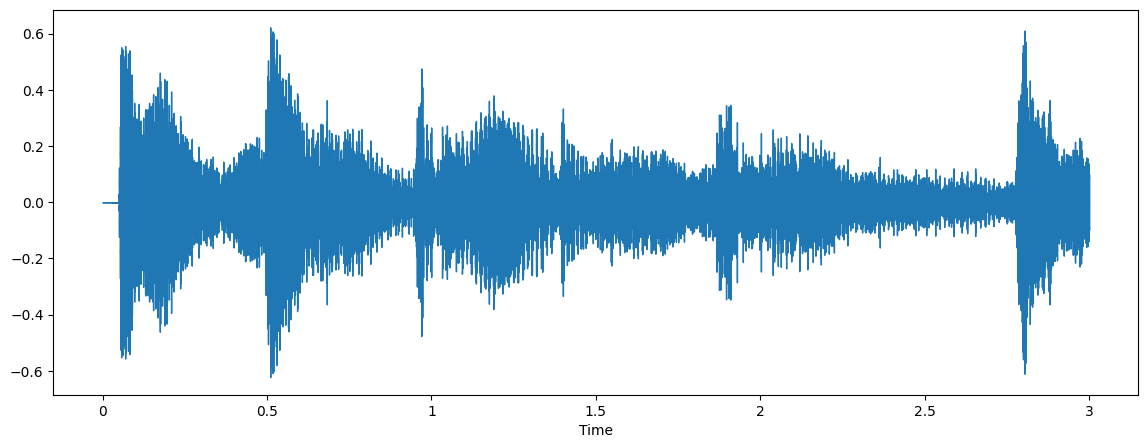

In [86]:
from random import randint

x = randint(0, len(feature_array)-1)
print("Plot audio sample", x)
plot.plot_waveform(feature_array[x, :], downsample_rate)

In [82]:
np.save('data/preprocessed_data.npy', feature_array)